# Data Exploring & Collection

Attribute Information Categorical Variables

Sex: sex of the patient [M: Male, F: Female]

ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]

RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

ExerciseAngina: exercise-induced angina [Y: Yes, N: No]

ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]

(Target) HeartDisease: output class [1: heart disease, 0: Normal]

Numeric Variables

Age: age of the patient [years]

RestingBP: resting blood pressure [mm Hg]

Cholesterol: serum cholesterol [mm/dl]

MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]

Oldpeak: oldpeak = ST [Numeric value measured in depression]

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

import lightgbm as lgb

from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve, accuracy_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


In [2]:
df = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


# EDA with Visulization

Sex
F    21.023965
M    78.976035
Name: Age, dtype: float64


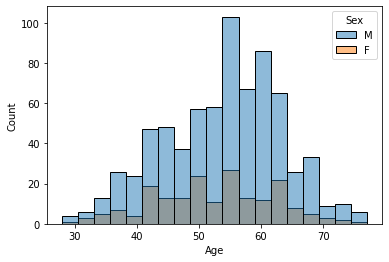

In [5]:
sns.histplot(x="Age",hue="Sex",data=df)
print(df.groupby("Sex")["Age"].count()*(100/len(df)))


**78 percent of the data consists of men**

Sex
F     9.84252
M    90.15748
Name: Age, dtype: float64


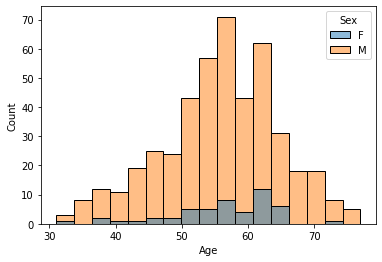

In [6]:
sns.histplot(x="Age",hue="Sex",data=df[df["HeartDisease"]==1])
print(df[df["HeartDisease"]==1].groupby("Sex")["Age"].count()*(100/len(df[df["HeartDisease"]==1])))


**90 percent of the data -where "HeartDisease" is 1- consists of men**


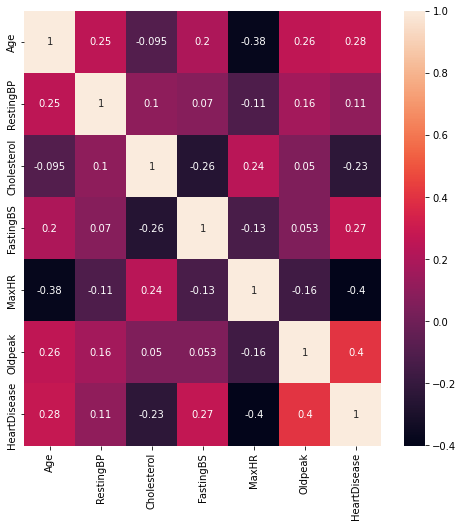

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

Oldpeak column has the highest positive correlation with HeartDisease

MaxHR column has the highest negative correlation with HeartDisease

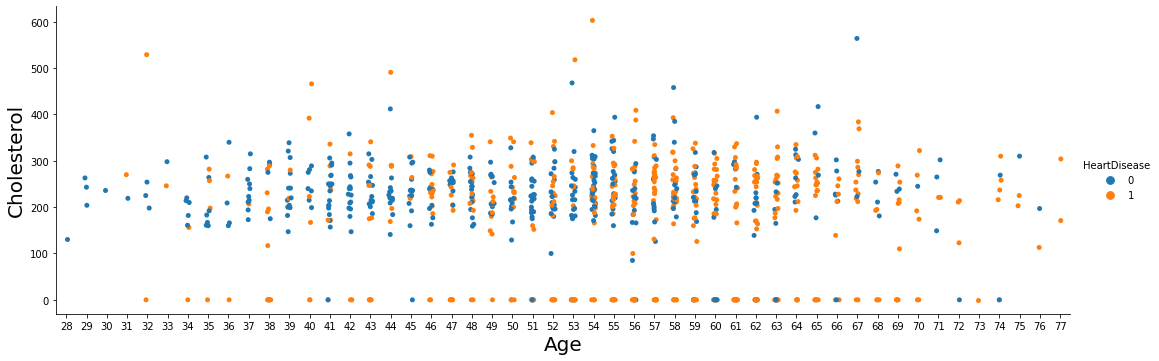

In [8]:
sns.catplot(x="Age",y="Cholesterol",hue="HeartDisease",data=df,aspect=3)
plt.xlabel("Age",fontsize=20)
plt.ylabel("Cholesterol",fontsize=20)
plt.show()

    Age around 60 years are the most affected to Heart Disease. And Age doesnt affect our data on Cholesterol levels much.

<AxesSubplot:xlabel='Age', ylabel='Oldpeak'>

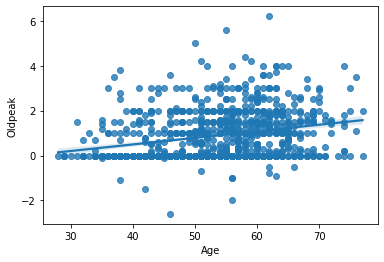

In [9]:
sns.regplot(x="Age",y="Oldpeak",data=df)

<AxesSubplot:xlabel='Age', ylabel='MaxHR'>

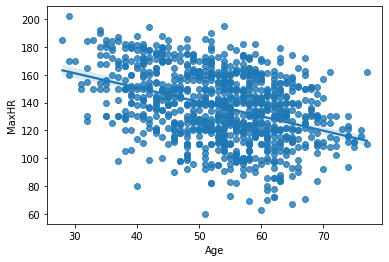

In [10]:
sns.regplot(x="Age",y="MaxHR",data=df)

According to the regplot above, Age affect MaxHR as Age increases,MaxHR decreases.

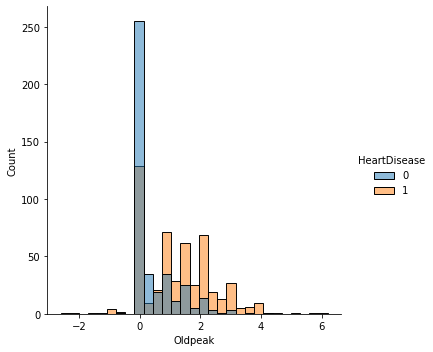

In [11]:
sns.displot(x="Oldpeak",data=df,hue="HeartDisease")

**According to the displot above; the higher the oldpeak, the higher the ratio of yellow in the bar. (Yellow indicate 1). So, Oldpeak noticeably affects HeartDisease**

# Pre-processing: Feature selection/extraction


In [12]:
CPT_oh = pd.get_dummies(df["ChestPainType"])
Sex_oh = pd.get_dummies(df["Sex"])
Ex_oh = pd.get_dummies(df["ExerciseAngina"])
ST_oh = pd.get_dummies(df["ST_Slope"])
rest_oh = pd.get_dummies(df["RestingECG"])

In [13]:
df.drop(["ChestPainType","Sex","RestingECG","ExerciseAngina","ST_Slope"],axis=1,inplace=True)

In [14]:
df = pd.concat([df,CPT_oh,Sex_oh,ST_oh,Ex_oh,rest_oh],axis=1)

In [15]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,ASY,ATA,NAP,...,F,M,Down,Flat,Up,N,Y,LVH,Normal,ST
0,40,140,289,0,172,0.0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0
1,49,160,180,0,156,1.0,1,0,0,1,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,1,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,0,...,1,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,0,1,...,0,1,0,0,1,1,0,0,1,0


In [16]:
X = df.drop(["HeartDisease"],axis=1)
y = df["HeartDisease"]

### Normalize Data


In [17]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

### Splitting Data

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.25,random_state=42)

# DATA MODELLİNG

In [19]:
# We will use this at the final to show best algorithm with best score
models_accuracy_scores = {}

In [20]:
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Random Forest Algorithm
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix


## Logistic Regression

In [21]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr,parameters,cv=10) 
logreg_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [22]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8633205456095482


In [23]:
y_hat = logreg_cv.predict(X_test)


              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



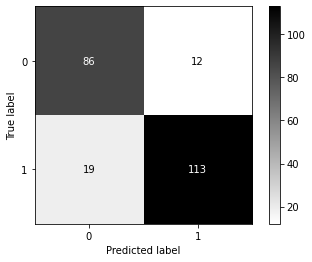

In [24]:
print(classification_report(y_test,y_hat))
plot_confusion_matrix(logreg_cv, X_test, y_test,cmap="binary") 


In [25]:
logreg_f1 = f1_score(y_test,y_hat,average="weighted")
logreg_accuracy = logreg_cv.score(X_test,y_test)
logreg_recall = recall_score(y_test,y_hat,average="binary")
models_accuracy_scores["Logistic Regression"] = [logreg_f1,logreg_accuracy,logreg_recall]


## K-Nearest Neighbors Classifier

#### Finding Best K

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics
Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=kNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.80869565, 0.78695652, 0.84782609, 0.83913043, 0.86521739,
       0.84347826, 0.86086957, 0.85652174, 0.86521739, 0.85652174,
       0.86521739, 0.87391304, 0.87391304, 0.86521739, 0.86956522,
       0.86956522, 0.87391304, 0.86521739, 0.8826087 , 0.8826087 ,
       0.8826087 , 0.87391304, 0.87826087, 0.87826087, 0.86956522,
       0.87826087, 0.87391304, 0.86521739, 0.86956522, 0.86956522,
       0.86956522, 0.87391304, 0.87826087, 0.86956522, 0.87391304,
       0.86086957, 0.86086957, 0.86086957, 0.86086957])

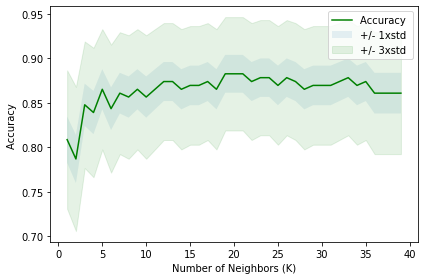

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [28]:
kNN = KNeighborsClassifier(n_neighbors = 28).fit(X_train,y_train)
y_hat = kNN.predict(X_test)
print(kNN.score(X_test,y_test))
print(metrics.accuracy_score(y_test, yhat))
    



0.8652173913043478
0.8608695652173913


              precision    recall  f1-score   support

           0       0.82      0.88      0.85        98
           1       0.90      0.86      0.88       132

    accuracy                           0.87       230
   macro avg       0.86      0.87      0.86       230
weighted avg       0.87      0.87      0.87       230



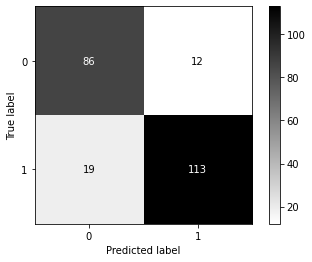

In [29]:
kNN = KNeighborsClassifier(n_neighbors = 28).fit(X_train,y_train)
y_hat = kNN.predict(X_test)
print(classification_report(y_test,y_hat))
plot_confusion_matrix(kNN, X_test, y_test,cmap="binary") 
    

In [30]:
kNN_f1 = f1_score(y_test,y_hat,average="weighted")
kNN_accuracy = kNN.score(X_test,y_test)
kNN_recall = recall_score(y_test,y_hat,average="binary")
models_accuracy_scores["K-Nearest Neighbors"] = [kNN_f1,kNN_accuracy,kNN_recall]

## Decision Tree Classifier

In [31]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

In [32]:
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree,parameters,cv=10)
tree_cv.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [33]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
accuracy : 0.8546462063086103


              precision    recall  f1-score   support

           0       0.79      0.87      0.83        98
           1       0.89      0.83      0.86       132

    accuracy                           0.85       230
   macro avg       0.84      0.85      0.85       230
weighted avg       0.85      0.85      0.85       230



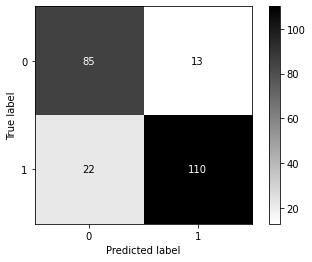

In [34]:
y_hat = tree_cv.predict(X_test)
print(classification_report(y_test,y_hat))
plot_confusion_matrix(tree_cv, X_test, y_test,cmap="binary") 

In [35]:
tree_f1 = f1_score(y_test,y_hat,average="weighted")
tree_accuracy = tree_cv.score(X_test,y_test)
tree_recall = recall_score(y_test,y_hat,average="binary")
models_accuracy_scores["Decision Tree Classifier"] = [tree_f1,tree_accuracy,tree_recall]

## Random Forest Classifier

In [36]:
rfc=RandomForestClassifier(n_estimators=400,random_state = 0,max_features='sqrt',n_jobs=-1)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=400, n_jobs=-1,
                       random_state=0)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87        98
           1       0.92      0.88      0.90       132

    accuracy                           0.89       230
   macro avg       0.88      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



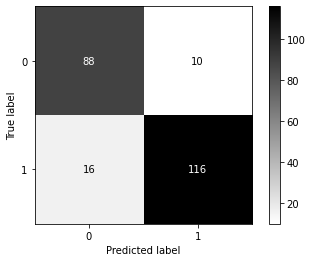

In [37]:
y_hat = rfc.predict(X_test)
print(classification_report(y_test,y_hat))
plot_confusion_matrix(rfc, X_test, y_test,cmap="binary") 

In [38]:
rfc_f1 = f1_score(y_test,y_hat,average="weighted")
rfc_accuracy = rfc.score(X_test,y_test)
rfc_recall = recall_score(y_test,y_hat,average="binary")
models_accuracy_scores["Random Forest Classifier"] = [rfc_f1,rfc_accuracy,rfc_recall]

## EVALUATION PART

In [39]:
names = ["F1-Score","Accuracy","Recall"]
df_scores = pd.DataFrame(models_accuracy_scores.values(),columns = names,index=models_accuracy_scores.keys())

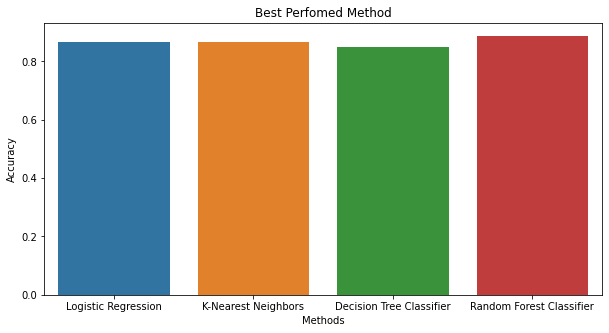

In [40]:
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
sns.barplot(y=df_scores["Accuracy"],x=df_scores.index)
 
plt.xlabel("Methods")
plt.ylabel("Accuracy")
plt.title("Best Perfomed Method")

plt.show()

In [41]:
df_scores

,F1-Score,Accuracy,Recall
Logistic Regression,0.865706,0.865217,0.856061
K-Nearest Neighbors,0.865706,0.865217,0.856061
Decision Tree Classifier,0.848481,0.847826,0.833333
Random Forest Classifier,0.887321,0.886957,0.878788


In [42]:
df_scores[df_scores["Accuracy"]==max(df_scores["Accuracy"])]

,F1-Score,Accuracy,Recall
Random Forest Classifier,0.887321,0.886957,0.878788
